# Pre-processing (Re-annotation)

![dandelion_logo](img/dandelion_logo_illustration.png)

## Foreword

***dandelion*** is written in `python=3.7.6` and is primarily a single-cell BCR-seq analysis package. It makes use of some tools from the fantastic [*immcantation suite*](https://immcantation.readthedocs.io/), implementing a workflow to streamline the pre-processing and exploratory stages for analyzing single-cell BCR-seq data from 10X Genomics. Post-processed data from ***dandelion*** can be smoothly transferred to [*scanpy*](https://scanpy.readthedocs.io/)/AnnData object for integration and exploration of BCR-seq data and RNA-seq data. I hope to be able to introduce some new single-cell BCR-seq exploratory tools down the road through *dandelion*. 

This section will cover the initial pre-processing of files after 10X's `Cell Ranger vdj` immune profiling data analysis pipeline **manually**. As mentioned, there is now a [singularity container](https://sc-dandelion.readthedocs.io/en/master/notebooks/singularity_preprocessing.html) that can automate the first few steps outlined below.


We will download the 10X data sets to process for this tutorial:
```bash
# create sub-folders
mkdir -p dandelion_tutorial/vdj_nextgem_hs_pbmc3
mkdir -p dandelion_tutorial/vdj_v1_hs_pbmc3
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_10k
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_1k

# change into each directory and download the necessary files
cd dandelion_tutorial/vdj_v1_hs_pbmc3;
wget -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.h5;
wget -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig_annotations.csv;
wget -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig.fasta;

cd ../vdj_nextgem_hs_pbmc3
wget -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_filtered_feature_bc_matrix.h5;
wget -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig_annotations.csv;
wget -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig.fasta;

cd ../sc5p_v2_hs_PBMC_10k;
wget -O filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
wget -O filtered_contig_annotations.csv https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig_annotations.csv;
wget -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig.fasta;

cd ../sc5p_v2_hs_PBMC_1k;
wget -O filtered_feature_bc_matrix.h5 wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_filtered_feature_bc_matrix.h5;
wget -O filtered_contig_annotations.csv wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig_annotations.csv;
wget -O filtered_contig.fasta https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig.fasta;
```

***dandelion***'s reannotation workflow requires the Cell Ranger fasta files and annotation files to start, particularly either *all_contig.fasta* or *filtered_contig.fasta* and corresponding *all_contig_annotations.csv* and *filtered_contig_annotations.csv*.

I'm running everything with the *filtered_contig* files as a standard analysis set up. I'm using a standard laptop for the analysis here: entry level 2017 Macbook Pro with 2.3 GHz Intel Core i5 processor and 16 GB 2133 MHz LPDDR3 ram.

If you followed the installation instructions, you should have the requisite auxillary softwares installed already. Otherwise, you can download them manually: [blast+](https://ftp.ncbi.nih.gov/blast/executables/igblast/release/LATEST/) and [igblast](https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/). For tigger-genotype, you can download it [here](https://bitbucket.org/kleinstein/immcantation/src/default/pipelines/). Just note that I made some minor modifications to this file, hence there is a version that comes with this package.

For convenience, in ***shell***, export the path to the database folders like as follows:
```bash
# bash/shell
echo "export GERMLINE=/Users/kt16/Documents/Github/dandelion/database/germlines/" >> ~/.bash_profile
echo "export IGDATA=/Users/kt16/Documents/Github/dandelion/database/igblast/" >> ~/.bash_profile
echo "export BLASTDB=/Users/kt16/Documents/Github/dandelion/database/blast/" >> ~/.bash_profile
# reload
source ~/.bash_profile
```
The databases for igblast are basically setup using [changeo's instructions](https://changeo.readthedocs.io/en/stable/examples/igblast.html). 

If you are using a jupyter notebook initialized via jupyterhub instance, you might want to try the fix to a known issue where pathing requires some adjustments https://github.com/zktuong/dandelion/issues/66.

For reannotation of constant genes, reference fasta files were downloaded from IMGT and only sequences corresponding to *CH1* region for each constant gene/allele were retained. The headers were trimmed to only keep the gene and allele information. Links to find the sequences can be found here : [***human***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Homo+sapiens) and [***mouse***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Mus).

The utility function `utl.makeblastdb` is a wrapper for:

```bash
# bash/shell
makeblastdb -dbtype nucl -parse_seqids -in $BLASTDB/human/human_BCR_C.fasta
```

So effectively, this does the same thing:
```python
# python
ddl.utl.makeblastdb('/Users/kt16/Documents/Github/dandelion/database/blast/human/human_BCR_C.fasta')
```

If you have cloned the directory from dandelion's github, you should have all the databases ready to go and would not need to run makeblastdb.

This section will now demonstrate how I batch process multiple samples/files from the same donor, as it will become important later on.

In [1]:
# Import modules
import sys
import os
import dandelion as ddl
ddl.logging.print_versions()

dandelion==0.1.3.post2.dev62 pandas==1.2.3 numpy==1.20.1 matplotlib==3.3.4 networkx==2.5 scipy==1.6.1 skbio==0.5.6


In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
# print current working directory
os.getcwd()

'/Users/kt16/Downloads/dandelion_tutorial'

## Step 1: Formatting the headers of the Cell Ranger fasta file
Here, I'm adding a prefix to the headers of each contig in the fasta files, via the function `pp.format_fastas`. The prefix is basically just the folder name, so in this case it's:
`sc5p_v2_hs_PBMC_1k`, `sc5p_v2_hs_PBMC_10k`, `vdj_v1_hs_pbmc3` and `vdj_nextgem_hs_pbmc3`.

The function will also create sub-folders where a new fasta file and all subsequent files will be located. The function will also add the prefix to the corresponding annotation file automatically and create a copy in the same folder as the formated fasta file. 

This is to ensure that the barcodes are consistent throughout so as not to interfere with subsequent integration with the gene expression data, which will be covered in subsequent sections. 

The file structure should look something like this later on if the settings are left as default. The tmp directory can be deleted once the initial preprocessing has completed.
```console
# bash/shell
(dandelion) mib113557i:dandelion_tutorial kt16$ tree sc5p_v2_hs_PBMC_1k
sc5p_v2_hs_PBMC_1k
├── dandelion
│   ├── filtered_contig.fasta
│   ├── filtered_contig_annotations.csv
│   ├── filtered_contig_igblast_db-pass_genotyped.tsv
│   └── tmp
│       ├── filtered_contig_igblast.fmt7
│       ├── filtered_contig_igblast.tsv
│       ├── filtered_contig_igblast_db-pass.blastsummary.txt
│       ├── filtered_contig_igblast_db-pass.tsv
│       ├── filtered_contig_igblast_db-pass.xml
│       ├── filtered_contig_igblast_db-pass_genotyped.tsv
│       ├── filtered_contig_igblast_db-pass_heavy_parse-select.tsv
│       └── filtered_contig_igblast_db-pass_light_parse-select.tsv
├── filtered_contig.fasta
├── filtered_contig_annotations.csv
└── filtered_feature_bc_matrix.h5
```

The first option of `pp.format_fastas` accepts a list of the fasta file paths to reformat, or list of names of folders containing the fasta files; each folder should only contain 1 fasta file, and 1 contig_annotation.csv. Make sure there's no hidden files and delete those if present.

You can provide `prefixes` and/or `suffixes` to add the the cell/contig barcodes as a list and they will be formatted accordingly. The prefixes/suffixes will be separated by an underscore (`_`) if left as default but that can be adjusted with the `sep` option. 

If you choose not to provide a prefix/suffix, then the function will simply make a copy of the original files and place it in the `dandelion` sub-folders.

For more complex experimental setups, such as with data from multiplexed experiments, please contact me (kt16@sanger.ac.uk) and I can walk you through a slightly more advanced set up.

In [3]:
# the first option is a list of fasta files to format and the second option is the list of prefix to add to each file.
samples = ['sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3']
ddl.pp.format_fastas(samples, prefix = samples)

Formating fasta(s) : 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


---

**Non-standard (filtered) input files**:

If you are not using `filtered` files, e.g. `all_contig.fasta`, please specify the `filename_prefix` option for all preprocessing functions below (except for quantify_mutations).

For example, use `filename_prefix = 'all'` for `all_contig.fasta`, or `filename_prefix = <insertprefix>` for any files that are named `<insertprefix>_contig.fasta`. 

If you are running more than 1 sample and if each filename prefix needs to be specified, `filename_prefix` in `ddl.pp.format_fastas` will accept a list of prefixes i.e. `filename_prefix = ['all', 'filtered', ...]`.

---

## Step 2: Reannotate the V/D/J genes with *igblastn*

Like immcantation, we will reannotate the V(D)J genes with igblastn using the latest IMGT reference databases. `pp.reannotate_genes` uses [*changeo*](https://changeo.readthedocs.io/en/stable/examples/10x.html)'s `AssignGenes.py` and `MakeDB.py` to call *igblastn* to reannotate the fasta files. All the column headers are now adhereing to the [*AIRR*](http://docs.airr-community.org/) standard.

In [4]:
ddl.pp.reannotate_genes(samples)

Assigning genes : 100%|██████████| 4/4 [07:19<00:00, 109.87s/it]


If you did not set a path to the igblast or germline paths in the environment above, you need to specify the path to the folders containing the fasta files directly.

```python
ddl.pp.reannotate_genes(samples, igblast_db = "database/igblast/", germline = "database/germlines/imgt/human/vdj/")
```

## Step 3 : Reassigning heavy chain V gene alleles *(optional but recommended)*

Next, we use *immcantation's TIgGER* method to reassign allelic calls for heavy chain V genes with `pp.reassign_alleles`. As stated in TIgGER's [website](https://tigger.readthedocs.io/en/stable/) and [manuscript](https://pubmed.ncbi.nlm.nih.gov/25675496/), *'TIgGER is a computational method that significantly improves V(D)J allele assignments by first determining the complete set of gene segments carried by an individual (including novel alleles) from V(D)J-rearrange sequences. TIgGER can then infer a subject’s genotype from these sequences, and use this genotype to correct the initial V(D)J allele assignments.'*

This impacts on how contigs are chosen for finding clones later. It is also important when considering to do mutational analysis. For convenience, germline sequences are reconstructed at this step using the corrected V-gene alleles. Therefore, it is highly recommended to run it. 

However, this will only work properly if there is sufficient contigs. An ideal scenario would be to run it on multiple samples from the same subject to allow for more information to be used to confidently assign a genotyped *v_call*. In this tutorial, I'm assuming the four samples can be split into two sets where sets of two corresponds to a different/single individual. So while important, this step can be skipped if you don't have enough data to do this. 

`pp.reassign_alleles` requires the `combined_folder` option to be specified so that a merged/concatenated file can be produced for running TIgGER.

Processing data file(s) : 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Concatenating objects
      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


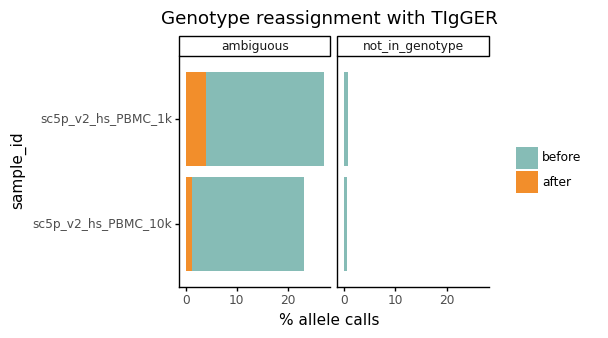

<ggplot: (342143629)>


Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


In [5]:
# reassigning alleles on the first set of samples
ddl.pp.reassign_alleles(samples[:2], combined_folder = 'tutorial_scgp1')

Processing data file(s) : 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Concatenating objects
      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.
Returning summary plot


/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


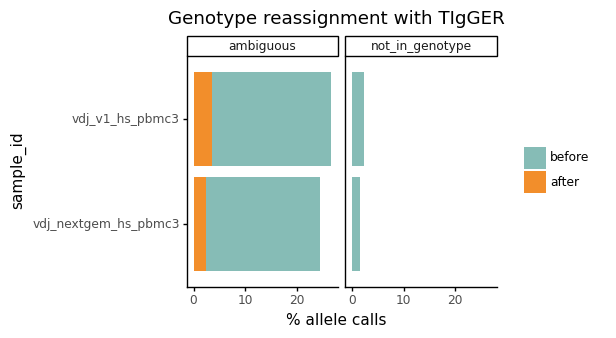

<ggplot: (344788537)>


Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


In [6]:
# reassigning alleles on the second set of samples
ddl.pp.reassign_alleles(samples[2:], combined_folder = 'tutorial_scgp2')

We can see that most of the original ambiguous V calls have now been corrected and only a few remain.

Similar to above, if you you can specify the path to the folder containing the fasta files accordingly:

```python
ddl.pp.reassign_alleles(samples[2:], combined_folder = 'tutorial_scgp2', germline = "database/germlines/imgt/human/vdj")
```

## Step 4: Assigning constant region calls

Cell Ranger's annotation files provides a *c_gene* column, but rather than simply relying on Cell Ranger's annotation, it is common to use [*immcantation-presto*'s *MaskPrimers.py*](https://presto.readthedocs.io/en/version-0.5.3---license-change/tools/MaskPrimers.html) with a custom primer list. 

As an alternative, `dandelion` includes a pre-processing function, `pp.assign_isotypes`, to use *blast* to annotate constant region calls for all contigs and retrieves the call, merging it with the tsv files. This function will overwrite the output from previous steps and add a *c_call* column at the end, or replace the existing column if it already exists. The Cell Ranger calls are returned as `c_call_10x`.

Further, to deal with incorrect constant gene calls due to insufficient length, a pairwise alignment will be run against [curated sequences](https://immunology.sciencemag.org/content/6/56/eabe6291) that were deemed to be highly specific in distinguishing `IGHA1` vs `IGHA2`, and `IGHG1` to `IGHG4`. I have also curated sets of sequences that should help deal with `IGLC3/6/7` as these are problematic too. If there is insufficient info, the `c_call` will be returned as a combination of the most aligned sets of sequences. Because of how similar the lambda light chains are, extremely ambiguous calls (only able to map to a common sequence across the light chains) will be returned as `IGLC`. This typically occurs when the constant sequence is very short. Those that have equal alignment scores between `IGLC3/6/7` sequences and the common sequence will be returned as a concatenated call; for example, a contig initially annotated as `IGLC3` will be returned as `IGLC,IGLC3`. 

---
The curated sequences can be updated/replaced with a dict-of-dict-of-dict style dictionary via the option `correction_dict`. The provided dictionary should be a nested dictionary like the following:
```python
primer_dict = {
    'IGHG':{
        'IGHG1':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCACCCTCCTCCAAGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG2':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCGGCCCTGGGC',
        'IGHG3':'GCTTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG4':'GCTTCCACCAAGGGCCCATCCGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGGGC'}}
```

The key for the first level of the dictionary is used for searching whether the string pattern exists in the `c_call`, and the second level holds the dictionary for the the reference sequences to align to. The keys in the second level are used for replacing the existing `c_call` annotation if it is returned with the highest alignment score. The function currently only accepts 2-4 reference sequences for the pairwise alignment.

---

Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 2059/2059 [00:18<00:00, 113.46it/s]


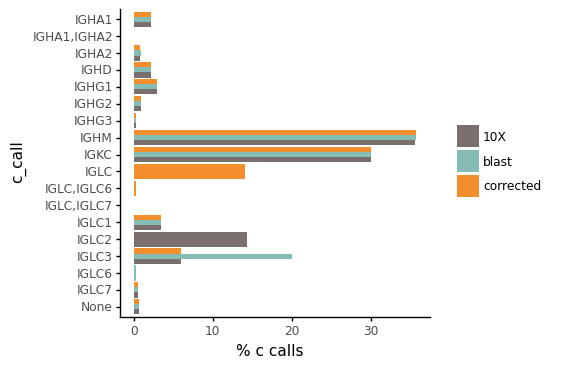

<ggplot: (349671201)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 2601/2601 [00:28<00:00, 90.70it/s] 


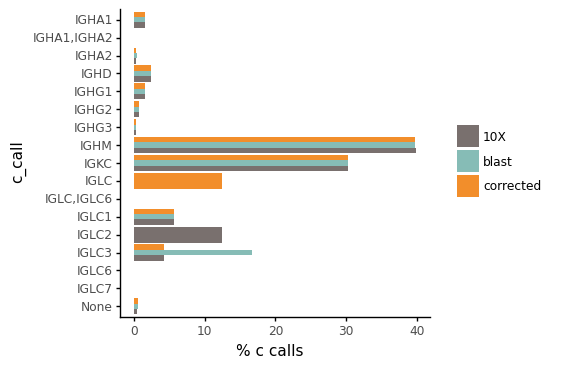

<ggplot: (349452577)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 2059/2059 [00:18<00:00, 113.83it/s]


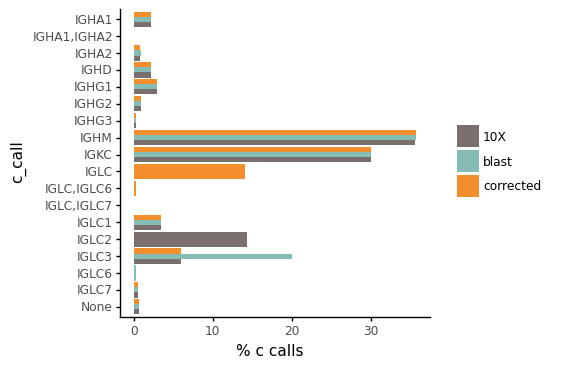

<ggplot: (347611561)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 3222/3222 [00:42<00:00, 75.61it/s]


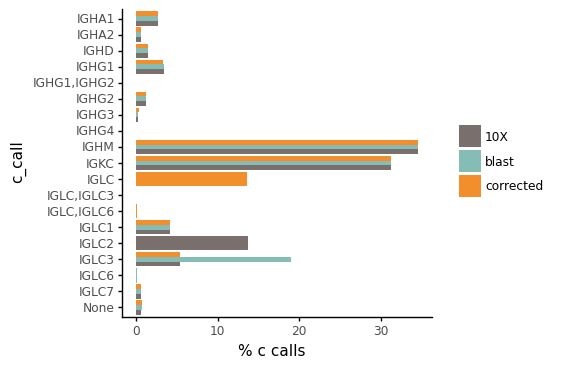

<ggplot: (352347573)>


In [7]:
ddl.pp.assign_isotypes(samples)

Should you want to use a different reference fasta file for this step, run with the following option:

```python
ddl.pp.assign_isotypes(samples, blastdb = "path/to/custom_BCR_constant.fasta")
```

This may take a while when dealing with large files; the number of cpus to size of file isn't exactly linear. Nevertheless, I have enabled parallelization as default because there were noticeable improvements in processing speeds with the smaller files. It should work faster with more cpus. The default option will return a summary plot that can be disabled with `plot = False`.

Finally, it's worthwhile to manually check the the sequences for constant calls returned as IGHA1-2, IGHG1-4 and the light chains and manually correct them if necessary.

## Step 5: Quantify mutations *(optional)*.

At this stage, with all the necessary columns in the files, you can quantify the basic mutational load with `pp.quantify_mutations`, a wrapper of `SHaZaM`'s basic mutational analysis in R, before subsequent analyses. This will be covered again later in the `Calculating diversity and mutation` section.

In [8]:
from tqdm import tqdm
# quantify mutations
for s in tqdm(samples, desc = 'Basic mutational load analysis '):
    filePath = s+'/dandelion/filtered_contig_igblast_db-pass_genotyped.tsv'
    ddl.pp.quantify_mutations(filePath)

Basic mutational load analysis : 100%|██████████| 4/4 [00:42<00:00, 10.74s/it]
